In [1]:
# COVID-19 infections per country
# Copyright 2020 Denis Meyer
#
# Data source:
# 2019 Novel Coronavirus COVID-19 (2019-nCoV) Data Repository by Johns Hopkins CSSE
# * https://github.com/CSSEGISandData/COVID-19
#
# Plot options
# * All countries
# * Countries with highest number of infections
# * Countries with highest number of deaths
# * Specific countries (infections)
# * Specific countries (deaths)
# * Curve fit (infections) for a specific country with predictions
# * Curve fit (deaths) for a specific country with predictions
# * Multi curve fit (infections) for a specific country
# * Multi curve fit (deaths) for a specific country
# * Curve fit (infections) for multiple countries with predictions
# * Curve fit (deaths) for multiple countries with predictions

In [2]:
import logging
import os
import datetime

import seaborn as sns

from src.Settings import SETTINGS
from src.PlotSettings import PLOT_SETTINGS

from src.Functions import Functions

from src.plots.AllCountries import PlotAllCountries
from src.plots.SpecificCountries import PlotSpecificCountries
from src.plots.HighestCountries import PlotHighestCountries
from src.plots.CurveFitSpecificCountry import PlotCurveFitSpecificCountry
from src.plots.MultiCurveFitSpecificCountry import PlotMultiCurveFitSpecificCountry
from src.plots.CurveFitMultiCountries import PlotCurveFitMultiCountries

In [3]:
functions = Functions()
functions.initialize_logger(SETTINGS['logging']['loglevel'], SETTINGS['logging']['format'], SETTINGS['logging']['date_format'])

# Set color palette
sns.set(palette='muted')

# Set current working directoy
csv_dir = os.path.join(os.getcwd(), SETTINGS['csv_subdir_name'])

# Set current date
current_date_str = datetime.date.today().strftime('%Y-%m-%d')

In [4]:
# Load 'confirmed' data
df = functions.get_data(csv_dir, SETTINGS['csv_infections_subdir_name'], SETTINGS['csv_infections_filename'].format(current_date_str), SETTINGS['datasource']['infections'], force_refresh_data=SETTINGS['force_refresh_data'])
# Drop unnecessary columns
df = df.drop(['Province/State', 'Lat', 'Long'], axis=1)

[07-04-2020 16:56:03] [INFO ] [Functions           :67  ] Not force refreshing data
[07-04-2020 16:56:03] [INFO ] [Functions           :68  ] Trying to load from file "C:\Users\deme\Code\GitHub\COVID-19-Infections-Per-Country\data\infections\time_series_19-covid-Confirmed-2020-04-07.csv"
[07-04-2020 16:56:03] [INFO ] [Functions           :71  ] Successfully loaded data from file "C:\Users\deme\Code\GitHub\COVID-19-Infections-Per-Country\data\infections\time_series_19-covid-Confirmed-2020-04-07.csv"


In [5]:
# Load 'deaths' data
df_deaths = functions.get_data(csv_dir, SETTINGS['csv_deaths_subdir_name'], SETTINGS['csv_deaths_filename'].format(current_date_str), SETTINGS['datasource']['deaths'], force_refresh_data=SETTINGS['force_refresh_data'])
# Drop unnecessary columns
df_deaths = df_deaths.drop(['Province/State', 'Lat', 'Long'], axis=1)

[07-04-2020 16:56:03] [INFO ] [Functions           :67  ] Not force refreshing data
[07-04-2020 16:56:03] [INFO ] [Functions           :68  ] Trying to load from file "C:\Users\deme\Code\GitHub\COVID-19-Infections-Per-Country\data\deaths\time_series_19-covid-Deaths-2020-04-07.csv"
[07-04-2020 16:56:03] [INFO ] [Functions           :71  ] Successfully loaded data from file "C:\Users\deme\Code\GitHub\COVID-19-Infections-Per-Country\data\deaths\time_series_19-covid-Deaths-2020-04-07.csv"


In [6]:
# Infections: Group by Country/Region, sum the values and reset the index
df_grouped_summed = df.groupby('Country/Region').sum().reset_index()
dates = list(df_grouped_summed.columns.values)[1:]
date_first = datetime.datetime.strptime(dates[0], '%m/%d/%y')
date_last = datetime.datetime.strptime(dates[-1], '%m/%d/%y')
logging.info('Working with "confirmed" data from {} to {}'.format(date_first.date(), date_last.date()))

[07-04-2020 16:56:03] [INFO ] [<ipython-input-6-6aa76c3aca33>:6   ] Working with "confirmed" data from 2020-01-22 to 2020-04-06


In [7]:
# Deaths: Group by Country/Region, sum the values and reset the index
df_deaths_grouped_summed = df_deaths.groupby('Country/Region').sum().reset_index()
dates_deaths = list(df_deaths_grouped_summed.columns.values)[1:]
date_first_deaths = datetime.datetime.strptime(dates_deaths[0], '%m/%d/%y')
date_last_deaths = datetime.datetime.strptime(dates_deaths[-1], '%m/%d/%y')
logging.info('Working with "deaths" data from {} to {}'.format(date_first_deaths.date(), date_last_deaths.date()))

[07-04-2020 16:56:03] [INFO ] [<ipython-input-7-eec008f97b43>:6   ] Working with "deaths" data from 2020-01-22 to 2020-04-06


In [8]:
# Initialize all plots

plot_all_countries = PlotAllCountries(functions, SETTINGS, PLOT_SETTINGS['all_countries'])
plot_specific_countries = PlotSpecificCountries(functions, SETTINGS, PLOT_SETTINGS['specific_countries'])
plot_highest_countries = PlotHighestCountries(functions, SETTINGS, PLOT_SETTINGS['highest_countries'])
plot_curve_fit_specific_country = PlotCurveFitSpecificCountry(functions, SETTINGS, PLOT_SETTINGS['curve_fit_specific_country'])
plot_multi_curve_fit_specific_country = PlotMultiCurveFitSpecificCountry(functions, SETTINGS, PLOT_SETTINGS['multi_curve_fit_specific_country'])
plot_curve_fit_multi_countries = PlotCurveFitMultiCountries(functions, SETTINGS, PLOT_SETTINGS['curve_fit_multi_countries'])

In [9]:
# Plot: All countries
plot_all_countries.plot(dates, df_grouped_summed, date_first, date_last)

[07-04-2020 16:56:03] [INFO ] [AllCountries        :37  ] Skipping plot "All countries"


[07-04-2020 16:56:03] [INFO ] [SpecificCountries   :44  ] Plotting "Specific countries (infections): "Germany, Spain, Iran, US, France, Korea, South, Switzerland, United Kingdom""
[07-04-2020 16:56:03] [INFO ] [SpecificCountries   :56  ] Plotting to days [45, 76]


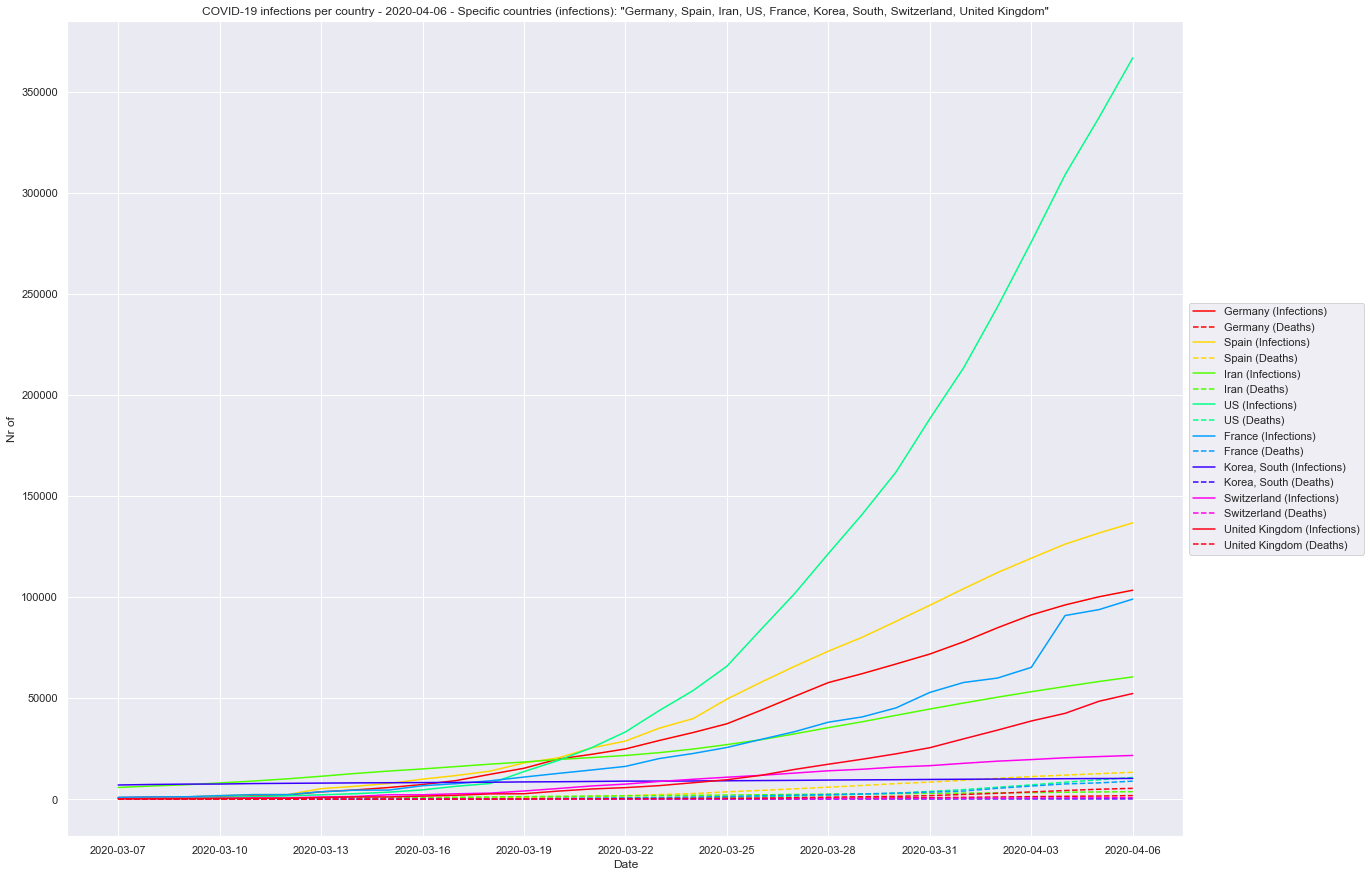

[07-04-2020 16:56:04] [INFO ] [Functions           :108 ] Saving plot to "C:\Users\deme\Code\GitHub\COVID-19-Infections-Per-Country\images\2020-04-06\Specific-Countries-Infections-Germany-Spain-Iran-US-France-Korea-South-Switzerland-UnitedKingdom.png"


In [10]:
# Plot: Specific countries - Infections
plot_specific_countries.plot_infections(dates, df_grouped_summed, df_deaths_grouped_summed, date_first, date_last)

[07-04-2020 16:56:05] [INFO ] [SpecificCountries   :108 ] Plotting "Specific countries (deaths): "Germany, Spain, Iran, US, France, Korea, South, Switzerland, United Kingdom""
[07-04-2020 16:56:05] [INFO ] [SpecificCountries   :120 ] Plotting to days [45, 76]


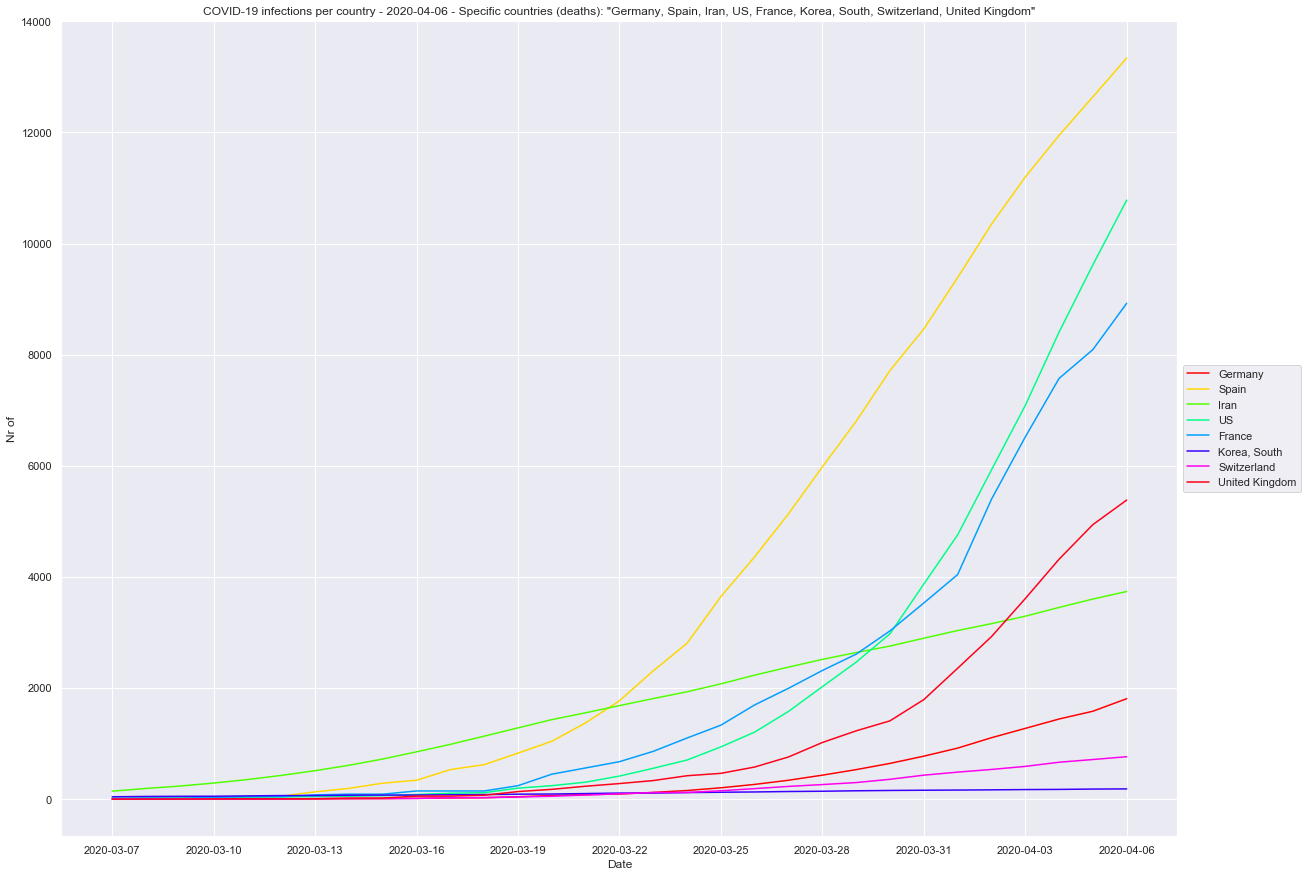

[07-04-2020 16:56:05] [INFO ] [Functions           :108 ] Saving plot to "C:\Users\deme\Code\GitHub\COVID-19-Infections-Per-Country\images\2020-04-06\Specific-Countries-Deaths-Germany-Spain-Iran-US-France-Korea-South-Switzerland-UnitedKingdom.png"


In [11]:
# Plot: Specific countries - Deaths
plot_specific_countries.plot_deaths(dates, df_grouped_summed, df_deaths_grouped_summed, date_first, date_last)

[07-04-2020 16:56:06] [INFO ] [HighestCountries    :45  ] Plotting "10 countries with highest number of infections"
[07-04-2020 16:56:06] [INFO ] [HighestCountries    :52  ] Plotting to days [46, 76]


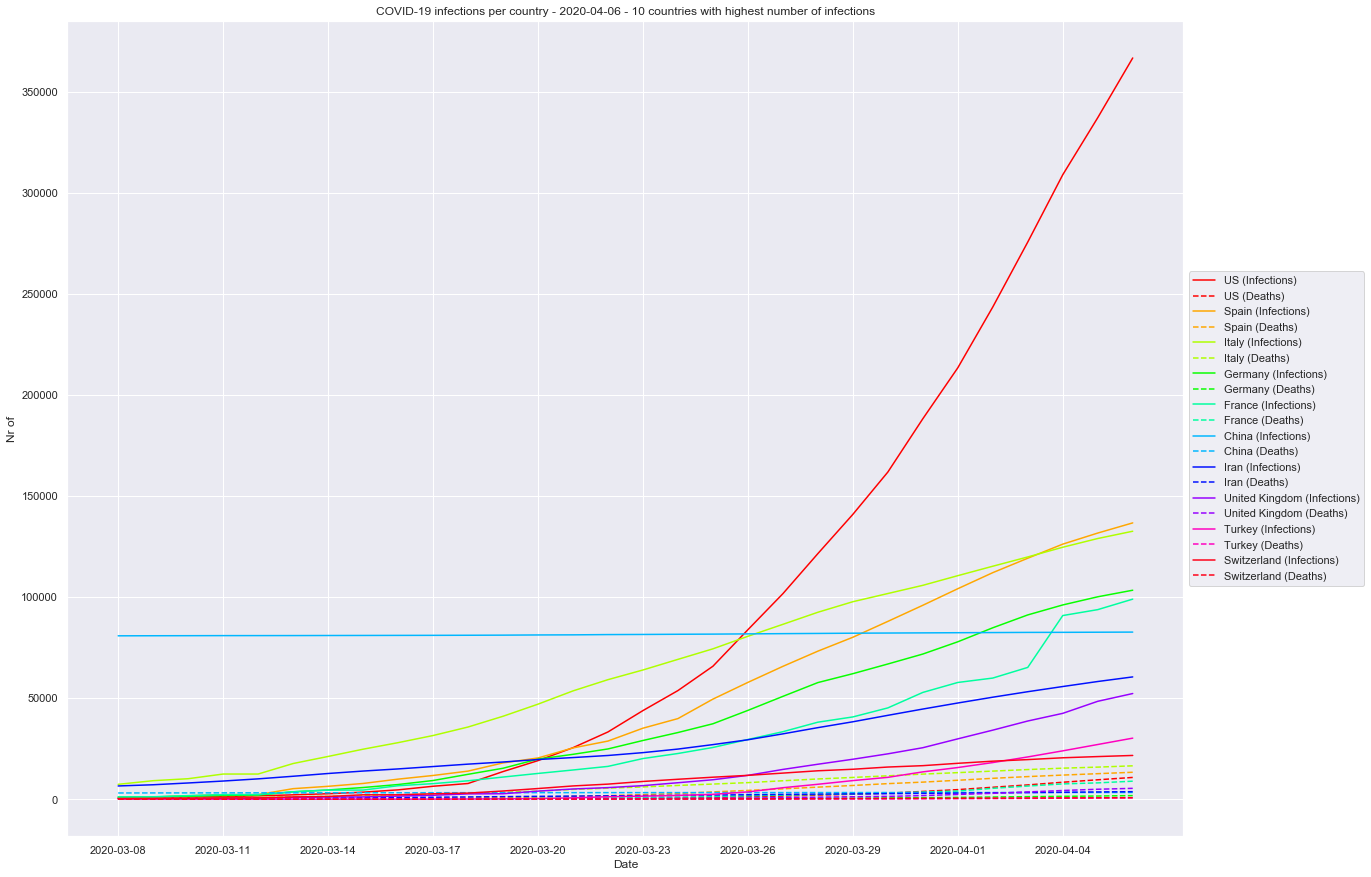

[07-04-2020 16:56:08] [INFO ] [Functions           :108 ] Saving plot to "C:\Users\deme\Code\GitHub\COVID-19-Infections-Per-Country\images\2020-04-06\10-Countries-With-Highest-Number-Of-Infections.png"


In [12]:
# Plot: Countries with highest numbers - Infections
plot_highest_countries.plot_infections(dates, df_grouped_summed, df_deaths_grouped_summed, date_first, date_last)

[07-04-2020 16:56:09] [INFO ] [HighestCountries    :112 ] Plotting "10 countries with highest number of deaths"
[07-04-2020 16:56:09] [INFO ] [HighestCountries    :119 ] Plotting to days [46, 76]


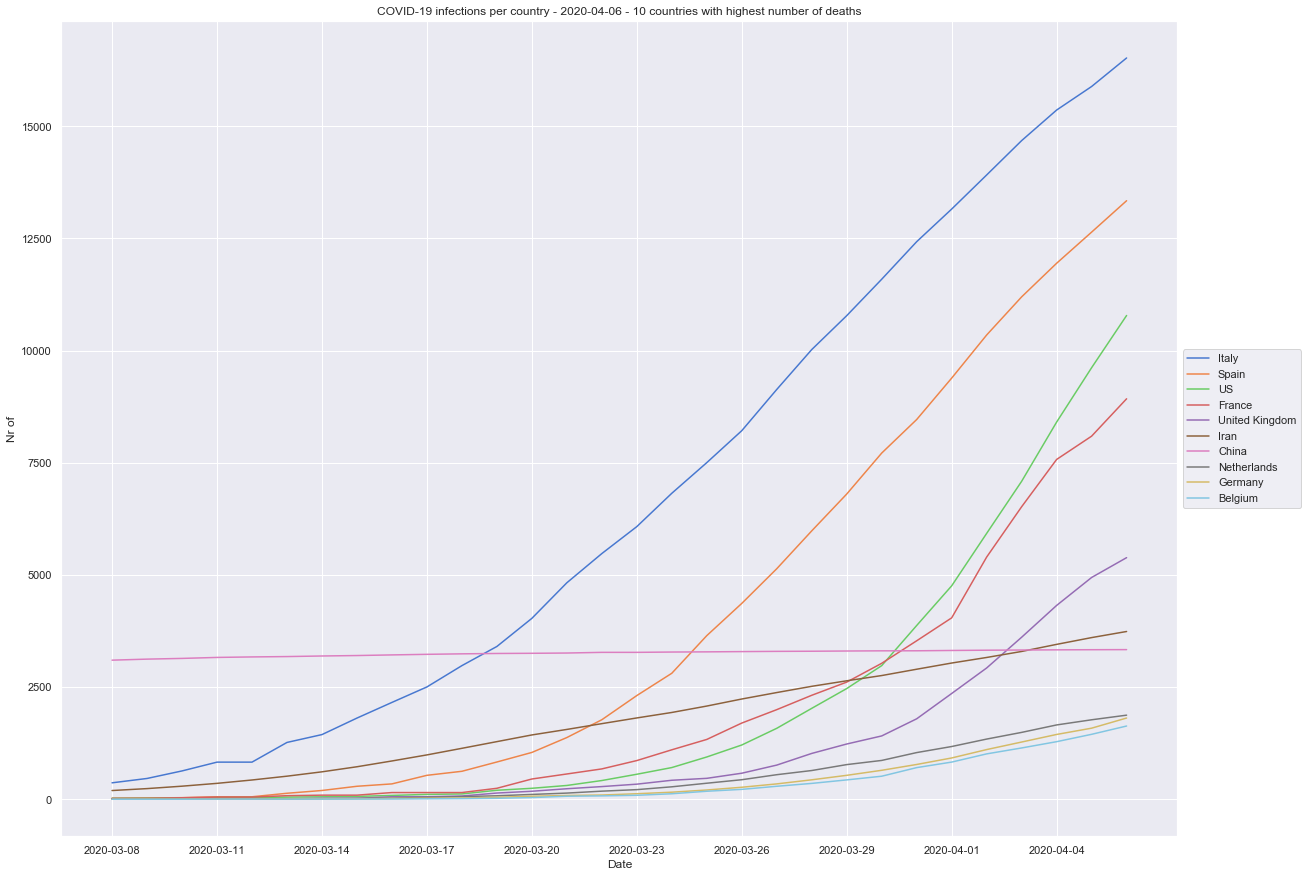

[07-04-2020 16:56:11] [INFO ] [Functions           :108 ] Saving plot to "C:\Users\deme\Code\GitHub\COVID-19-Infections-Per-Country\images\2020-04-06\10-Countries-With-Highest-Number-Of-Deaths.png"


In [13]:
# Plot: Countries with highest numbers - Deaths
plot_highest_countries.plot_deaths(dates, df_grouped_summed, df_deaths_grouped_summed, date_first, date_last)

[07-04-2020 16:56:12] [INFO ] [CurveFitSpecificCountry:60  ] Plotting "Curve fit (infections) for country "Germany" with 4 day(s) prediction"
[07-04-2020 16:56:12] [INFO ] [CurveFitSpecificCountry:80  ] Fitting to days [67, 75]
[07-04-2020 16:56:12] [INFO ] [CurveFitSpecificCountry:90  ] Plotting to days [40, 80]
C:\Users\deme\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


40


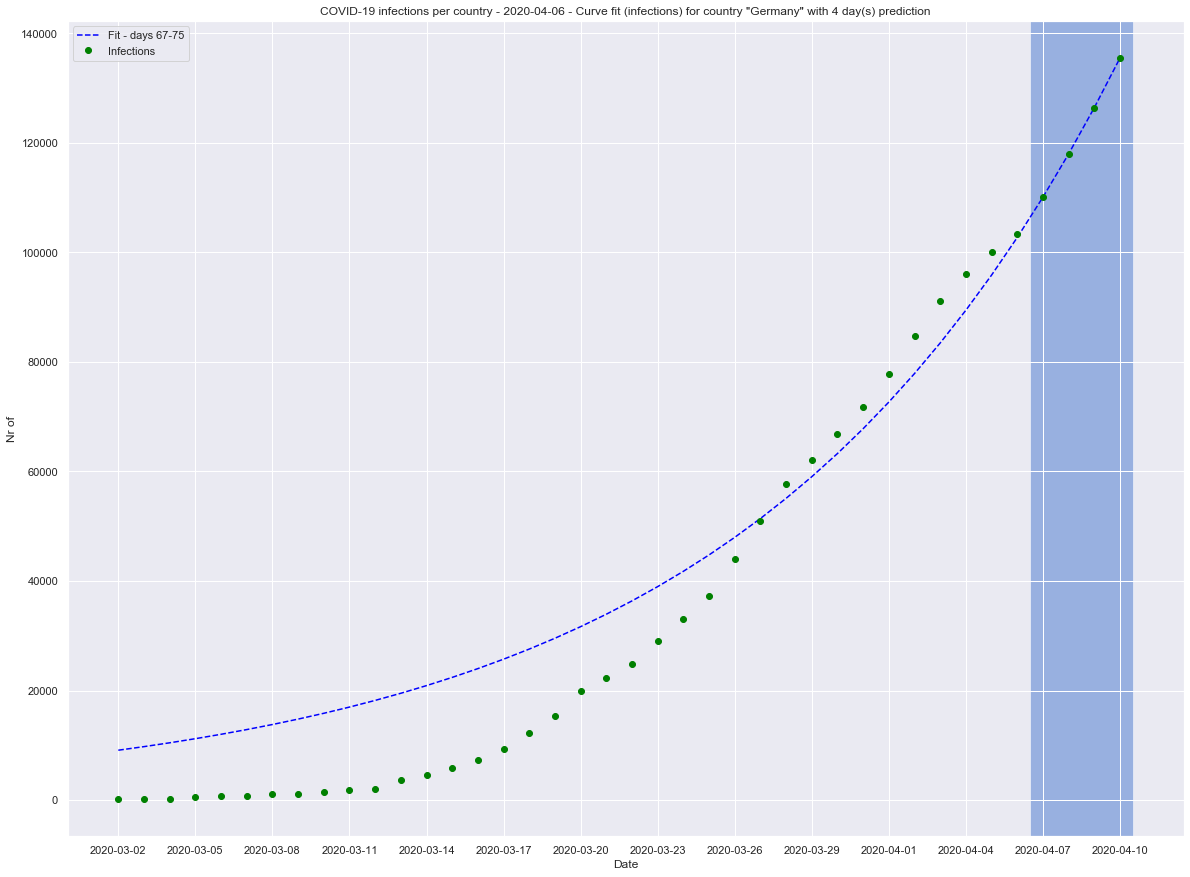

[07-04-2020 16:56:13] [INFO ] [Functions           :108 ] Saving plot to "C:\Users\deme\Code\GitHub\COVID-19-Infections-Per-Country\images\2020-04-06\Curve-Fit-Infections-Germany.png"


In [14]:
# Plot: Curve fit specific country - Infections
plot_curve_fit_specific_country.plot_infections(dates, df_grouped_summed, df_deaths_grouped_summed, date_first, date_last)

[07-04-2020 16:56:13] [INFO ] [CurveFitSpecificCountry:163 ] Plotting "Curve fit (deaths) for country "Germany" with 4 day(s) prediction"
[07-04-2020 16:56:13] [INFO ] [CurveFitSpecificCountry:183 ] Fitting to days [67, 75]
[07-04-2020 16:56:13] [INFO ] [CurveFitSpecificCountry:193 ] Plotting to days [40, 80]
C:\Users\deme\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


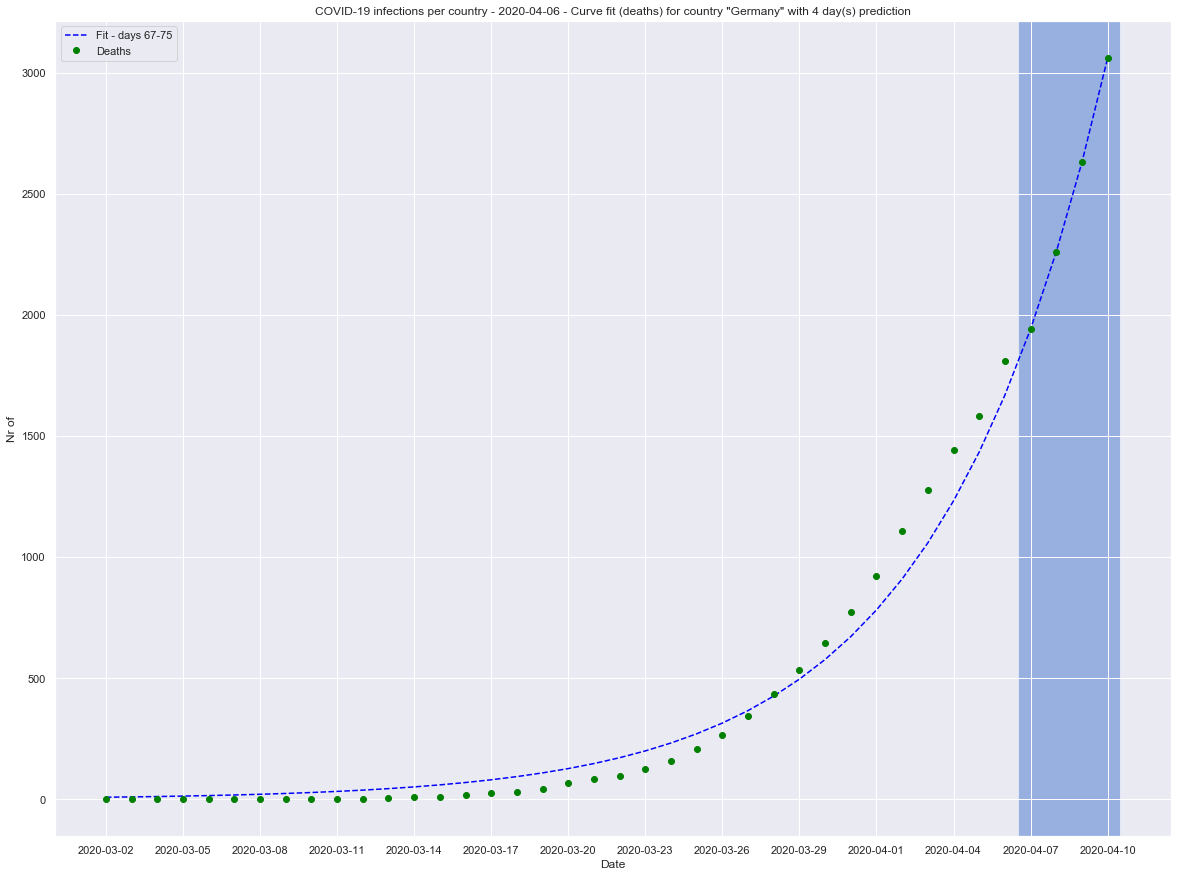

[07-04-2020 16:56:13] [INFO ] [Functions           :108 ] Saving plot to "C:\Users\deme\Code\GitHub\COVID-19-Infections-Per-Country\images\2020-04-06\Curve-Fit-Deaths-Germany.png"


In [15]:
# Plot: Countries with highest numbers - Deaths
plot_curve_fit_specific_country.plot_deaths(dates, df_grouped_summed, df_deaths_grouped_summed, date_first, date_last)

[07-04-2020 16:56:14] [INFO ] [MultiCurveFitSpecificCountry:100 ] Plotting "Multi curve fit (infections) for country "Germany""
[07-04-2020 16:56:14] [INFO ] [MultiCurveFitSpecificCountry:118 ] Fitting to days [40, 50]
[07-04-2020 16:56:14] [INFO ] [MultiCurveFitSpecificCountry:123 ] Plotting to days [40, 52]
C:\Users\deme\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
[07-04-2020 16:56:14] [INFO ] [MultiCurveFitSpecificCountry:118 ] Fitting to days [51, 58]
[07-04-2020 16:56:14] [INFO ] [MultiCurveFitSpecificCountry:123 ] Plotting to days [49, 64]
C:\Users\deme\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
[07-04-2020 16:56:14] [INFO ] [MultiCurveFitSpecificCountry:118 ] Fitting to days [58, 65]
[07-04-2020 16:56:14] [INFO ] [MultiCurveFitSpecificCountry:123 ] Plotting 

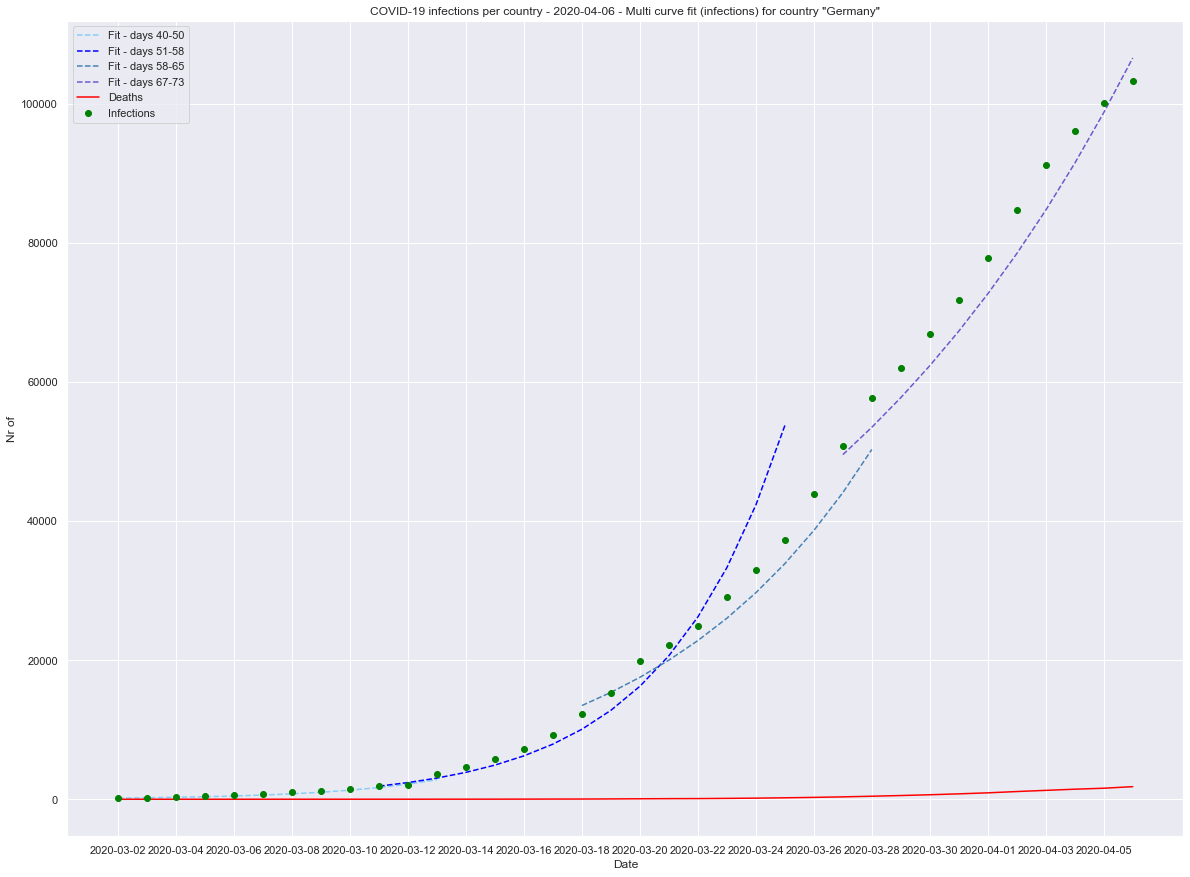

[07-04-2020 16:56:15] [INFO ] [Functions           :108 ] Saving plot to "C:\Users\deme\Code\GitHub\COVID-19-Infections-Per-Country\images\2020-04-06\Multi-Curve-Fit-Infections-Germany.png"


In [16]:
# Plot: Curve fit specific country - Infections
plot_multi_curve_fit_specific_country.plot_infections(dates, df_grouped_summed, df_deaths_grouped_summed, date_first, date_last)

[07-04-2020 16:56:15] [INFO ] [MultiCurveFitSpecificCountry:191 ] Plotting "Multi curve fit (deaths) for country "Germany""
[07-04-2020 16:56:15] [INFO ] [MultiCurveFitSpecificCountry:209 ] Fitting to days [51, 58]
[07-04-2020 16:56:15] [INFO ] [MultiCurveFitSpecificCountry:214 ] Plotting to days [40, 62]
C:\Users\deme\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
[07-04-2020 16:56:15] [INFO ] [MultiCurveFitSpecificCountry:209 ] Fitting to days [66, 73]
[07-04-2020 16:56:15] [INFO ] [MultiCurveFitSpecificCountry:214 ] Plotting to days [58, 76]
C:\Users\deme\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
[07-04-2020 16:56:15] [INFO ] [MultiCurveFitSpecificCountry:246 ] Calculating ticks for days [40, 76]


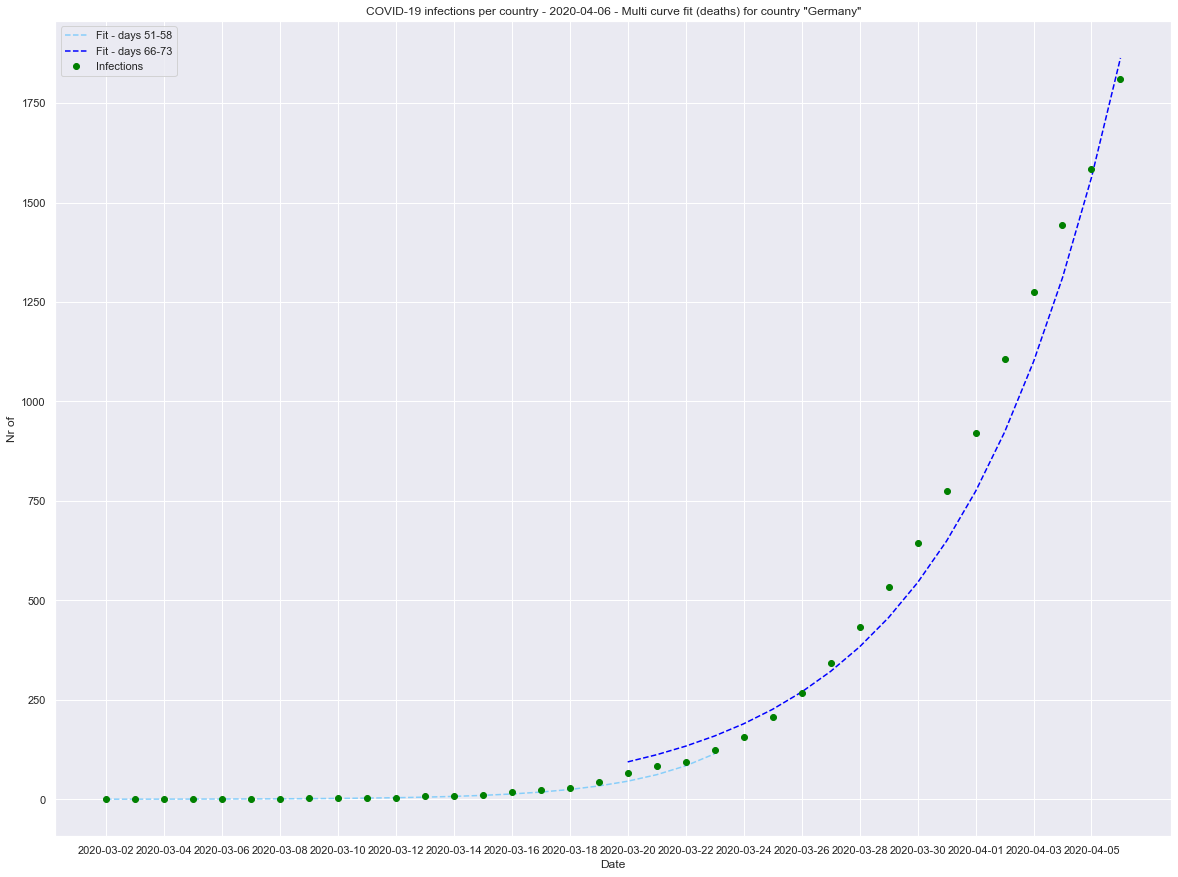

[07-04-2020 16:56:16] [INFO ] [Functions           :108 ] Saving plot to "C:\Users\deme\Code\GitHub\COVID-19-Infections-Per-Country\images\2020-04-06\Multi-Curve-Fit-Deaths-Germany.png"


In [17]:
# Plot: Countries with highest numbers - Deaths
plot_multi_curve_fit_specific_country.plot_deaths(dates, df_grouped_summed, df_deaths_grouped_summed, date_first, date_last)

[07-04-2020 16:56:16] [INFO ] [CurveFitMultiCountries:84  ] Plotting "Curve fit (infections) for countries "Italy, US, Spain, Germany" with 4 days prediction"
[07-04-2020 16:56:16] [INFO ] [CurveFitMultiCountries:100 ] Plotting to days [40, 80]
[07-04-2020 16:56:16] [INFO ] [CurveFitMultiCountries:105 ] Preparing country "Italy"
[07-04-2020 16:56:16] [INFO ] [CurveFitMultiCountries:122 ] Fitting to days [66, 73]
C:\Users\deme\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
[07-04-2020 16:56:16] [INFO ] [CurveFitMultiCountries:105 ] Preparing country "US"
[07-04-2020 16:56:16] [INFO ] [CurveFitMultiCountries:122 ] Fitting to days [66, 73]
C:\Users\deme\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
[07-04-2020 16:56:16] [INFO ] [CurveFitMultiCountries:105 ] Preparing countr

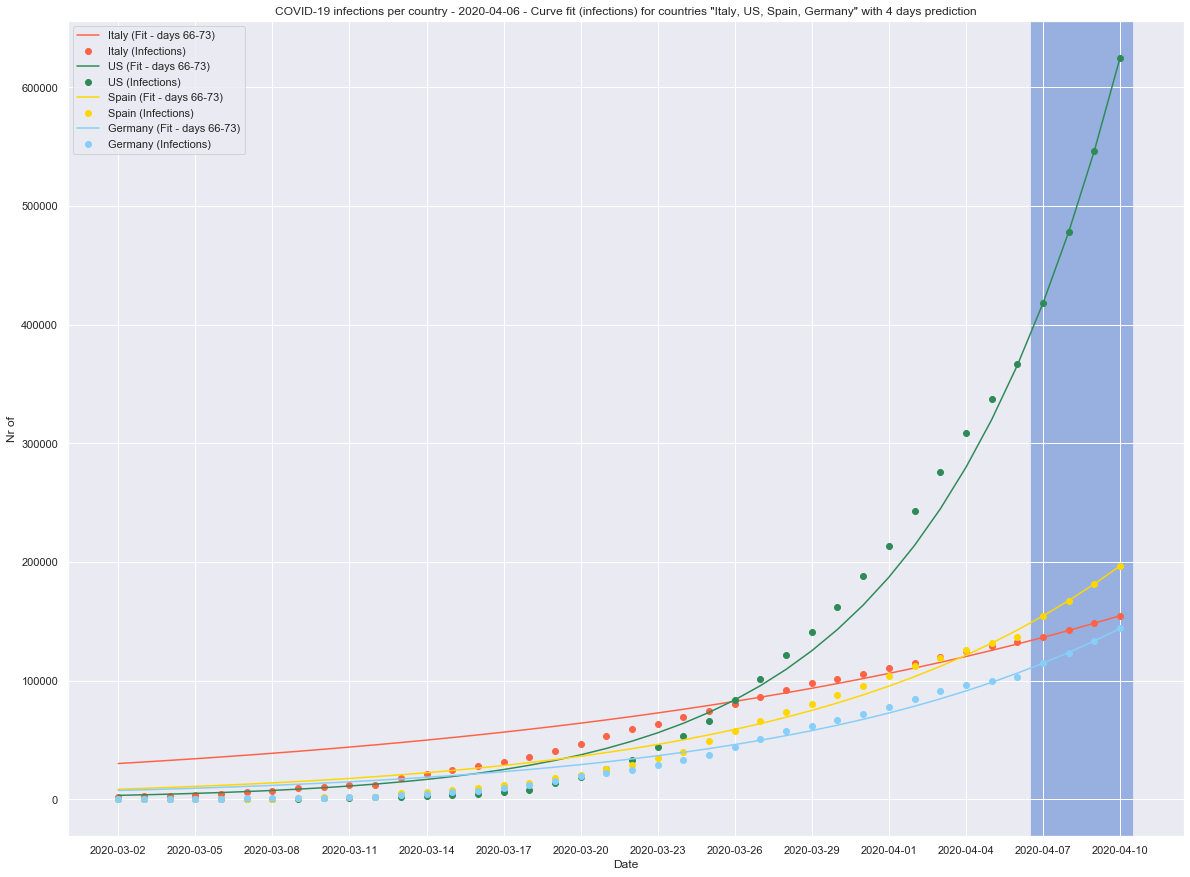

[07-04-2020 16:56:17] [INFO ] [Functions           :108 ] Saving plot to "C:\Users\deme\Code\GitHub\COVID-19-Infections-Per-Country\images\2020-04-06\Curve-Fit-Infections-Italy-US-Spain-Germany.png"


In [18]:
# Plot: Curve fit multiple countries - Infections
plot_curve_fit_multi_countries.plot_infections(dates, df_grouped_summed, df_deaths_grouped_summed, date_first, date_last)

[07-04-2020 16:56:17] [INFO ] [CurveFitMultiCountries:200 ] Plotting "Curve fit (deaths) for countries "Italy, US, Spain, Germany" with 4 days prediction"
[07-04-2020 16:56:17] [INFO ] [CurveFitMultiCountries:215 ] Plotting to days [40, 80]
[07-04-2020 16:56:17] [INFO ] [CurveFitMultiCountries:220 ] Preparing country "Italy"
[07-04-2020 16:56:17] [INFO ] [CurveFitMultiCountries:237 ] Fitting to days [66, 73]
C:\Users\deme\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
[07-04-2020 16:56:17] [INFO ] [CurveFitMultiCountries:220 ] Preparing country "US"
[07-04-2020 16:56:17] [INFO ] [CurveFitMultiCountries:237 ] Fitting to days [66, 73]
C:\Users\deme\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
[07-04-2020 16:56:17] [INFO ] [CurveFitMultiCountries:220 ] Preparing country "S

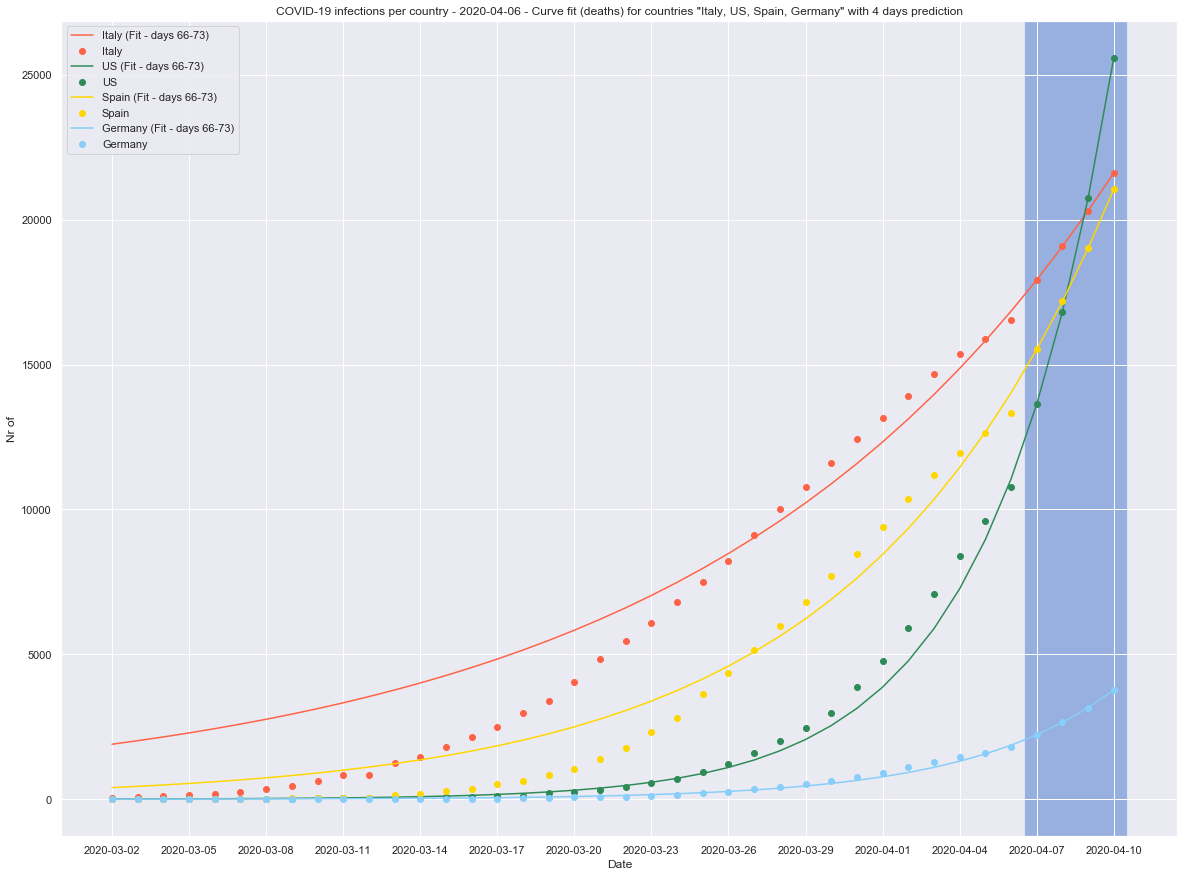

[07-04-2020 16:56:18] [INFO ] [Functions           :108 ] Saving plot to "C:\Users\deme\Code\GitHub\COVID-19-Infections-Per-Country\images\2020-04-06\Curve-Fit-Deaths-Italy-US-Spain-Germany.png"


In [19]:
# Plot: Countries with highest numbers - Deaths
plot_curve_fit_multi_countries.plot_deaths(dates, df_grouped_summed, df_deaths_grouped_summed, date_first, date_last)